In [1]:
%run ~/CPPN/utils.py
from matplotlib import animation

In [2]:
data_name = 'polblogs'
# graph_name = data_name + '_0.01edges_Meta-Train.npy'
graph_name = data_name + '_0.1_minmax.npy'

pre_attack_dataset = data_name + '.npz'

graph_dict = get_graph(graph_name = graph_name,
                       attack_type = 'prognn', 
                       pre_attack_dataset = pre_attack_dataset, 
                       )

features = graph_dict['features']#scipy.sparse.csr_array(graph_dict['features'].cpu().numpy())
labels = graph_dict['labels']
adj = graph_dict['adj']
idx_train = graph_dict['idx_train']
idx_test = graph_dict['idx_test']
idx_val = graph_dict['idx_val']
graph = graph_dict['graph']


Using Attacked Data
Selecting 1 largest connected components
Graph Disconnected
Adding Random Edges to Connect Graph
Adding Random Edge :  663 1127


In [3]:
# # graph.remove_edges_from(nx.selfloop_edges(graph))
# degrees = np.array(list(dict(graph.degree).values()))

# edge_index = torch.tensor(list(graph.edges)).t().contiguous()
# train_graph = graph

# # Create train test splits
# edges = set(graph.edges)

# train_edges = set(nx.minimum_spanning_tree(graph).edges)
# num_train_edges = int(0.8 * len(edges)) - len(train_edges)

# allowed_edges = list(edges.difference(train_edges))
# train_edge_idx = np.random.choice(range(len(allowed_edges)), replace = False, size = num_train_edges)
# for idx in train_edge_idx:
#     train_edges.add(allowed_edges[idx])
    
# test_edges = edges.difference(train_edges)

# assert train_edges.intersection(test_edges) == set()

# overall_edge_index = torch.tensor(np.array(list(edges)), dtype = torch.long).T.to(device)
# edge_index_train = torch.tensor(np.array(list(train_edges)), dtype = torch.long).T.to(device)
# edge_index_test = torch.tensor(np.array(list(test_edges)), dtype = torch.long).T.to(device)

# test_neg = negative_sampling(edge_index_test,
#                              num_nodes = len(graph),
#                              num_neg_samples = len(test_edges),
#                              method = 'dense')

# train_neg = negative_sampling(edge_index_train,
#                              num_nodes = len(graph),
#                              num_neg_samples = len(train_edges),
#                              method = 'dense')




# split_edge = {'train' : {'edge' : edge_index_train.T, 
#                         # 'edge_neg' : train_neg.T},
#               'test' : {'edge' : edge_index_test[:, edge_index_test.shape[1]//2:].T,
#                         'edge_neg' : test_neg[:, test_neg.shape[1]//2:].T}, 
#               'valid' : {'edge' : edge_index_test[:, :edge_index_test.shape[1]//2].T, 
#                          'edge_neg' : test_neg[:, :test_neg.shape[1]//2].T}}

# edge_index = split_edge['train']['edge'].T.to(device)



In [4]:
class CPPN(torch.nn.Module):
    
    def __init__(self, in_feats, num_classes = None, num_layers = 2, num_hidden = 128, dropout = 0.1):
        super(CPPN, self).__init__()
        
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.in_feats = in_feats
        self.num_classes = num_classes
        self.dropout = dropout
        
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(self.in_feats, self.num_hidden))
        # self.class_layer_zero = torch.nn.Linear(self.num_hidden, self.num_hidden)
        # self.class_layer = torch.nn.Linear(self.num_hidden, self.num_classes)
        
        for _ in range(self.num_layers - 2):
            self.lins.append(torch.nn.Linear(self.num_hidden, self.num_hidden))
            
        self.lins.append(torch.nn.Linear(self.num_hidden, 1))
    
    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
            
    def forward(self, x):
        
        for idx, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = F.dropout(x, p = self.dropout, training = self.training)
            x = F.relu(x)

        # c = self.class_layer_zero(x)
        # c = self.class_layer(c)
        
        x = self.lins[-1](x)
        
        return x #torch.sigmoid(x)

In [5]:
core_nodes = list(nx.k_core(graph).nodes)

In [6]:
core_lengths = np.array([[nx.shortest_path_length(graph, i, n) for n in core_nodes] for i in tqdm(range(len(graph)))])
norm_core_lengths = (core_lengths - np.min(core_lengths)) / np.ptp(core_lengths)

100%|██████████| 1222/1222 [00:01<00:00, 929.70it/s]


In [7]:
# Hop Distance 
len_adj = []
for n in tqdm(graph.nodes):
    lengths = dict(nx.single_source_dijkstra_path_length(graph, n))
    len_adj.append(np.array(list(dict(sorted(lengths.items(), key = lambda item: item[0])).values())))
len_adj = np.array(len_adj)

# norm_len_adj = (len_adj - np.min(len_adj)) / np.ptp(len_adj)



100%|██████████| 1222/1222 [00:14<00:00, 86.15it/s]


In [8]:
# len_adj[len_adj == 1] = 0
# len_adj[len_adj == 2] = 0
# len_adj[len_adj == 3] = 0
norm_len_adj = (len_adj - np.min(len_adj)) / np.ptp(len_adj)


In [9]:
# train_adj = torch.zeros_like(adj)
# train_adj[list(split_edge['train']['edge'][:, 0].detach().cpu().numpy()),
# list(split_edge['train']['edge'][:, 1].detach().cpu().numpy())] = 1

In [10]:
dgi = DGIEmbedding(graph = graph, 
           embed_dim = 32, 
           feature_matrix = features.detach().cpu(), 
           batch_size = 1, 
           patience = 25,
           model_name = '_')

dgi.embed()
embed = dgi.get_embedding()
context = np.mean(embed, axis = 0)

/home/shafi.z/CPPN/DGI/utils/process.py:211: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/torch/csrc/utils/tensor_new.cpp:621.)
  return torch.sparse.FloatTensor(indices, values, shape)
 23%|██▎       | 575/2500 [00:09<00:31, 60.84it/s] 


In [11]:
a1 = adj @ adj
a2 = a1 @ adj
a3 = a2 @ adj
a4 = a3 @ adj
a5 = a4 @ adj

a1 = a1 - torch.diag(a1) * torch.eye(a1.shape[0], a1.shape[1]).to(device)
a2 = a2 - torch.diag(a2) * torch.eye(a1.shape[0], a1.shape[1]).to(device)
a3 = a3 - torch.diag(a3) * torch.eye(a1.shape[0], a1.shape[1]).to(device)
a4 = a4 - torch.diag(a4) * torch.eye(a1.shape[0], a1.shape[1]).to(device)
a5 = a5 - torch.diag(a5) * torch.eye(a1.shape[0], a1.shape[1]).to(device)


In [12]:
a1 = a1.detach().cpu().numpy()
a2 = a2.detach().cpu().numpy()
a3 = a3.detach().cpu().numpy()
a4 = a4.detach().cpu().numpy()
a5 = a5.detach().cpu().numpy()


In [13]:
hops = np.concatenate([a1, a2, a3, a4, a5], axis = 0)

In [14]:
hops = (hops - np.min(hops)) / np.ptp(hops)

In [15]:

a1 = hops[:a1.shape[0], :]
a2 = hops[a1.shape[0]:2*a1.shape[0], :]
a3 = hops[2*a1.shape[0]:3*a1.shape[0], :]
a4 = hops[3*a1.shape[0]:4*a1.shape[0], :]
a5 = hops[4*a1.shape[0]:, :]


In [16]:
# Coordinates
x_mat = np.tile((np.arange(adj.shape[0]) / adj.shape[0]), (adj.shape[0], 1)).T 
y_mat = np.tile((np.arange(adj.shape[1]) / adj.shape[1]), (adj.shape[1], 1)).T 

# Node Features
np_feat = (features @ features.T).detach().cpu().numpy()
np_feat = (np_feat - np.min(np_feat)) / np.ptp(np_feat)

# Hop Length 
norm_len_adj = (len_adj - np.min(len_adj)) / np.ptp(len_adj)

# Curvature
deg = torch.sum(adj, axis = 1)
curv = 4 - deg.unsqueeze(1) - deg.unsqueeze(0)
curv = (curv - torch.min(curv)) / (torch.max(curv) - torch.min(curv))
curv = curv.detach().cpu().numpy()

# Input Matrix
# norm_len_adj
in_mat = np.stack([x_mat, y_mat, np_feat, curv, a1, a2, a3, a4] +\
                  [np.ones((adj.shape[0], adj.shape[0])) * context[i] for i in range(context.shape[0])],
                  -1)

# Structural Features 
sense_feat_dict, sense_features = get_sense_features(graph)
feat_map = np.zeros((sense_features.shape[0], sense_features.shape[0], 2 * sense_features.shape[1]))
for i in range(sense_features.shape[0]):
    for j in range(sense_features.shape[0]):
        feat_map[i, j, :] = np.concatenate([sense_features[i], sense_features[j]])

# Lengths to Core Nodes
core_map = np.zeros((norm_core_lengths.shape[0], norm_core_lengths.shape[0], 2 * norm_core_lengths.shape[1]))
for i in range(norm_core_lengths.shape[0]):
    for j in range(norm_core_lengths.shape[0]):
        core_map[i, j, :] = np.concatenate([norm_core_lengths[i], norm_core_lengths[j]])



in_mat = np.concatenate([in_mat, feat_map, core_map], axis = -1)
# in_mat = np.concatenate([in_mat, core_map], axis = -1)

in_mat = torch.Tensor(in_mat)
in_mat = in_mat.to(device)


num_feats = 8 + core_map.shape[-1] + feat_map.shape[-1]

cppn = CPPN(in_feats = num_feats + context.shape[0],
            num_layers = 10,
            num_classes = labels.max() + 1,
            num_hidden = 64,
            dropout = 0.15).to(device)

optimizer = optim.Adam(cppn.parameters(),
                       lr = 5e-4,
                       weight_decay = 5e-6)

# r = list(split_edge['train']['edge'][:, 0].detach().cpu().numpy()) + list(split_edge['train']['edge_neg'][:, 0].detach().cpu().numpy())
# c = list(split_edge['train']['edge'][:, 1].detach().cpu().numpy()) + list(split_edge['train']['edge_neg'][:, 1].detach().cpu().numpy())



# out_list = []
cppn.train()
print ("Training")
for e in range(2000):
    optimizer.zero_grad()
    out = cppn(in_mat)
    out = out.reshape(adj.shape[0], adj.shape[0])
    # out = (out + out.T) / 2
    # out_list.append(out.detach().cpu().numpy())

    # recon_adj = out 
    # recon_deg = torch.sum(recon_adj, axis = 1)
    # recon_curv = 4 - recon_deg.unsqueeze(1) - recon_deg.unsqueeze(0)    
    
    # curv_loss = torch.sum(torch.square(recon_curv - curv))
    diff = out - adj
    #diff = diff[r, c]
    edge_loss = torch.sum(torch.square(diff)) 
    # class_loss = (100 * F.nll_loss(F.log_softmax(torch.diagonal(class_out).T[idx_train], dim = 1), labels[idx_train]))
    loss = edge_loss #+ (1e-5 * curv_loss) 
    loss.backward()
    optimizer.step()
    print ("Epoch : ", e, "Loss : ", loss.item(), end = '\r')#, "Curvature Loss : ", curv_loss.item(), ")", end = '\r')

Training                                                  


In [17]:
edge_loss

tensor(22120.5332, device='cuda:0', grad_fn=<SumBackward0>)

In [19]:
recon_adj = (out + out.T) / 2
best_diff = np.inf
best_t = None
deg = torch.sum(adj, axis = 1)
curv = 4 - deg.unsqueeze(1) - deg.unsqueeze(0)
for t in np.arange(100) / 100: 
    recon_deg = torch.sum(recon_adj > t, axis = 1)
    recon_curv = 4 - recon_deg.unsqueeze(1) - recon_deg.unsqueeze(0)
    c_diff = torch.sum(torch.abs(recon_curv - curv))
    if c_diff < best_diff: 
        best_diff = c_diff
        best_t = t

recon_deg = torch.sum(recon_adj > best_t, axis = 1)
recon_curv = 4 - recon_deg.unsqueeze(1) - recon_deg.unsqueeze(0)
# recon_curv = (recon_curv - torch.min(recon_curv)) / (torch.max(recon_curv) - torch.min(recon_curv))


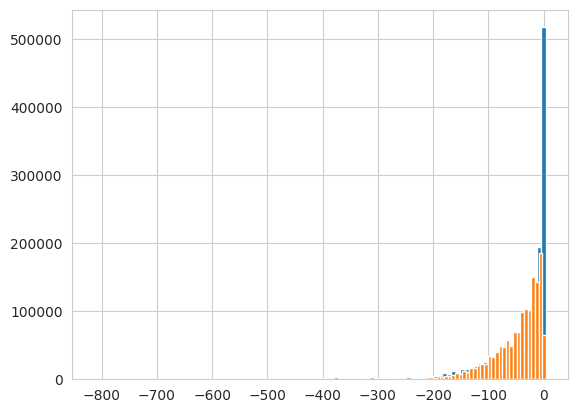

In [20]:
plt.hist(recon_curv.detach().cpu().numpy().flatten(), bins = 100)
plt.hist(curv.detach().cpu().numpy().flatten(), bins = 100)

plt.show()

In [13]:
# p = [out[a,b].item() for a, b in split_edge['test']['edge'].detach().cpu().numpy()]
# n = [out[a,b].item() for a, b in split_edge['test']['edge_neg'].detach().cpu().numpy()]
# preds = p + n
# print ("AUC : ", roc_auc_score([1 for _ in range(len(p))] +[0 for _ in range(len(p))], preds))
# results = {}
# evaluator.K = 50
# test_hits = evaluator.eval({
#             'y_pred_pos': np.array(p),
#             'y_pred_neg': np.array(n),
#         })[f'hits@50']
# print ("Hits@10 : ", test_hits)

In [14]:
# feat_map = np.concatenate([sense_features[:, None, :],
#                            np.repeat(sense_features[None, :, :],
#                                      sense_features.shape[0],
#                                      axis = 0)],
#                           axis=-1)


In [15]:
# cppn = CPPN(in_feats = 3 + context.shape[0], num_layers = 2, num_hidden = 64).to(device)
# optimizer = optim.Adam(cppn.parameters(), lr = 1e-3, weight_decay = 5e-4)
# out_list = []
# cppn.train()

# for e in range(2000):
#     optimizer.zero_grad()
#     out = cppn(in_mat).reshape(adj.shape[0], adj.shape[0])
#     out_list.append(out.detach().cpu().numpy())
#     loss = torch.sum(torch.square(out - adj))
#     loss.backward()
#     optimizer.step()
#     print ("Epoch : ", e, "Loss : ", loss.item(), end = '\r')

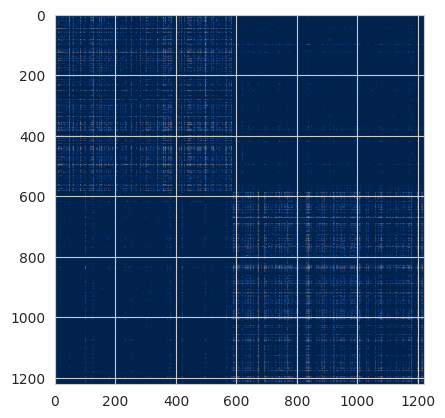

In [21]:
cppn.eval()
out = cppn(in_mat).detach().cpu().numpy().reshape(adj.shape[0], adj.shape[0])
plt.imshow(out > best_t, cmap = 'cividis')# > np.mean(out))
plt.show()

# plt.imshow(adj.detach().cpu().nump



# plt.show()

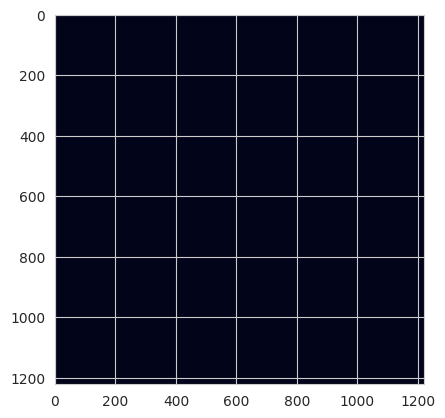

In [210]:
idx = 15
plt.imshow(out_list[idx] > np.mean(out_list[idx]))

In [171]:
np.mean(out_list[0] - out_list[29])

0.020596027

In [22]:
out_list = []

context_ = context.copy()

for _ in tqdm(range(500)):
    in_mat = np.stack([x_mat, y_mat, np_feat, norm_len_adj] +\
                      [np.ones((adj.shape[0], adj.shape[0])) * context_[i] for i in range(context.shape[0])],
                      -1)
    in_mat = np.concatenate([in_mat, feat_map, core_map], axis = -1)
    in_mat = torch.Tensor(in_mat)
    in_mat = in_mat.to(device)
    
    cppn.eval()
    out = cppn(in_mat).detach().cpu().numpy().reshape(adj.shape[0], adj.shape[0])
    out_list.append(out)
    context_ = context_ + np.random.normal(loc = 0, scale = context/5, size = (context.shape))

100%|██████████| 500/500 [15:46<00:00,  1.89s/it]


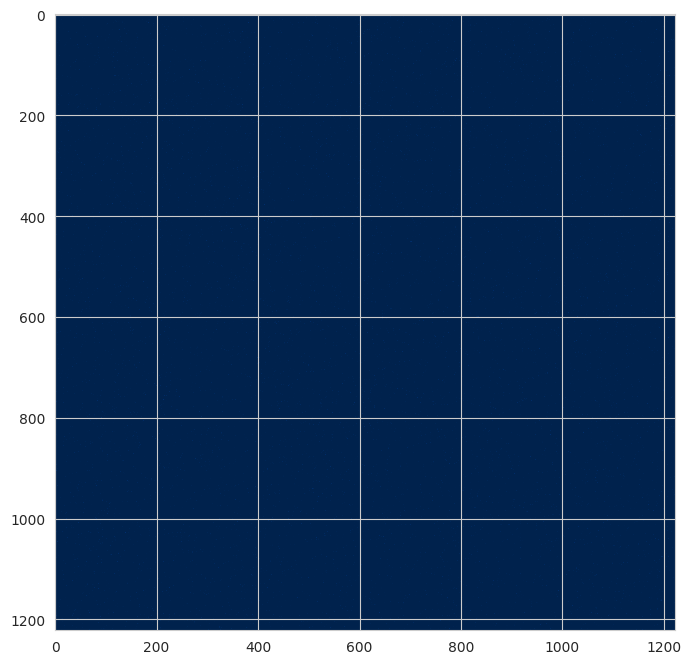

In [20]:
fps = 30
nSeconds = 50
snapshots = [a > np.mean(a) for a in out_list]

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize = (8, 8))

a = snapshots[0]
im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1,  cmap = 'cividis')

def animate_func(i):
    print('Frame : ', i, end = '\r')

    im.set_array(snapshots[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = len(snapshots),#nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('polblogs_gen.gif', fps=fps)

In [170]:
best_t

0.25

In [26]:
idx = 0
# cppn_adj = out_list[idx] > np.mean(out_list[idx])
out = (out + out.T) / 2
cppn_adj = out > best_t
cppn_adj = torch.Tensor(cppn_adj.astype(int)).type(torch.float32).to(device)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
surrogate = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1, nhid=16,
                with_relu=False, device=device)
surrogate = surrogate.to(device)
surrogate.fit(features, cppn_adj, labels, idx_train)
plain_gcn_test = surrogate.test(idx_test)

Test set results: loss= 0.3898 accuracy= 0.8674


In [187]:
# a = nx.Graph(out > np.mean(out))

idx = 250
a = nx.Graph(out_list[idx] > np.mean(out_list[idx]))

NameError: name 'out_list' is not defined

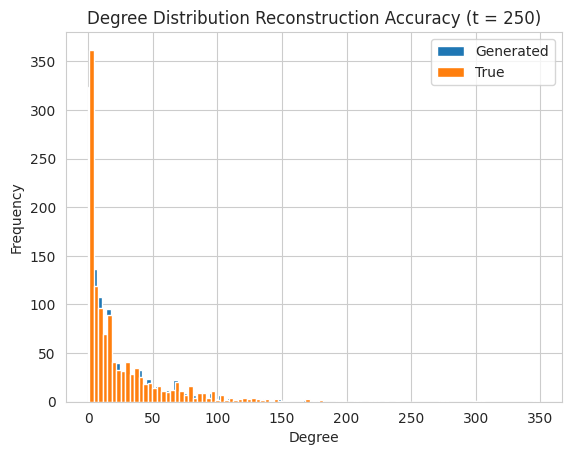

In [89]:
plt.hist(list(dict(nx.degree(a)).values()), bins = 100, label = 'Generated')
plt.hist(list(dict(nx.degree(graph)).values()), bins = 100, label = 'True')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution Reconstruction Accuracy (t = ' + str(idx) + ')')
plt.show()

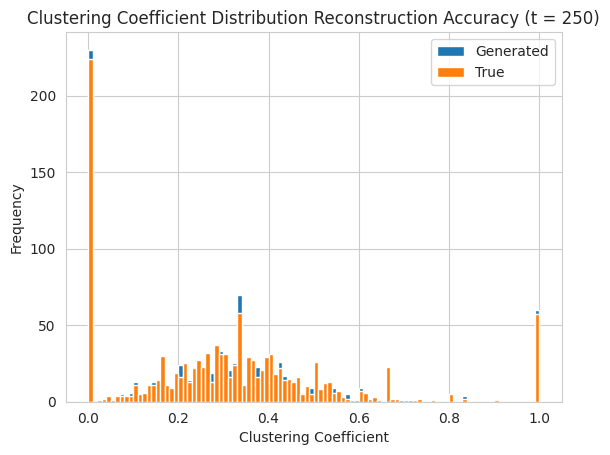

In [90]:
plt.hist(list(nx.clustering(a).values()), bins = 100, label = 'Generated')
plt.hist(list(nx.clustering(graph).values()), bins = 100, label = 'True')
plt.legend()
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Clustering Coefficient Distribution Reconstruction Accuracy (t = ' + str(idx) + ')')
# plt.xscale('log')
plt.show()